In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.interpolate import UnivariateSpline
import math
%matplotlib inline

In [46]:
# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=12)

# linear fit function
def linfit(x,a,b):
    return a + b * x

def find_nearest(array,value):
    '''
        function to find closest x data value corresponding to given y  
    '''
    idx = np.searchsorted(array, value, side='left')
    if idx > 0 and (idx == len(array) or np.abs(value - array[idx-1]) < np.abs(value - array[idx])):
        return (array[idx-1],idx-1)
    else:
        return (array[idx],idx)

# Constant-current (CC) method

The CC method evaluates the threshold voltage
as the value of the gate voltage, $\mathrm{V}_{\mathrm{gs}}$, corresponding to a
given arbitrary constant drain current, $\mathrm{I}_{\mathrm{d}}$ for a fixed value of drain voltage $\mathrm{V}_{\mathrm{ds}}$. 
This arbitrary constant drain
current is fixed at $(\mathrm{W}_{\mathrm{m}}/\mathrm{L}_{\mathrm{m}}) \times 10^{-7}$,  where $\mathrm{W}_{\mathrm{m}}$ and $\mathrm{L}_{\mathrm{m}}$ are the
channel width and length. 

In our case $\mathrm{W}_{\mathrm{m}} = 1~\mu \mathrm{m}$ and $\mathrm{L}_{\mathrm{m}} = 0.18~\mu \mathrm{m}$.

Reference to [this paper](https://www.researchgate.net/publication/220456459_A_review_of_recent_MOSFET_threshold_voltage_extraction_methods).

In [47]:
# find constant reference drain current 
Iref = (1 / 0.18 * 10**-7) * 1e06 # uA
print('The reference drain current is %1.2f uA'%Iref) 

Vd = 0.01 # drain voltage in Volts 

The reference drain current is 0.56 uA


The schematics is reproduced on LTSpice, as in the following picture:

![circuito](schematics.png)

The drain voltage $\mathrm{V}_{\mathrm{ds}}$ was fixed at 10 mV and $\mathrm{V}_{\mathrm{gs}}$ was varied from 0 to 3 V. 
The drain current $\mathrm{I}_{\mathrm{d}}$ was measured across the small resistance $\mathrm{R}_1$.

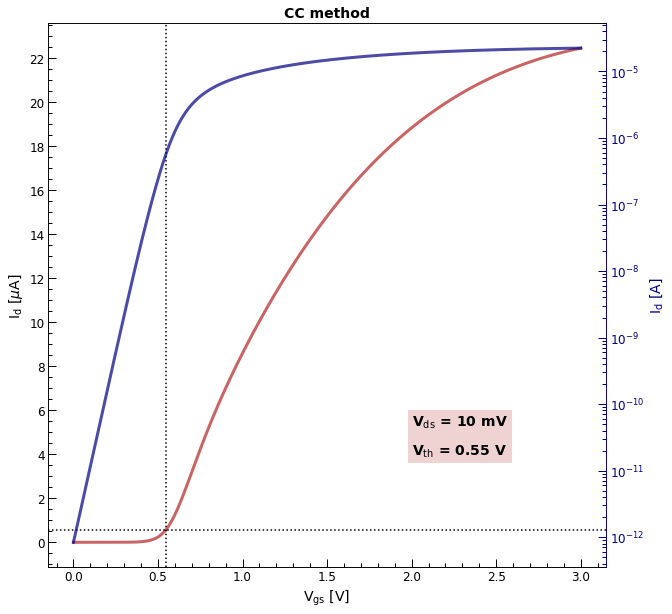

In [57]:
## -- CC method analysis -- ##
fig, ax = plt.subplots(figsize=(10,10))

# unpack data
vgs,i = np.loadtxt("Ids_Vds10m.txt", unpack=True,skiprows=1)

ax.plot(vgs, i*1e06, color='firebrick', ls='-', alpha=0.7, lw=3)

ax.set_title("CC method",fontsize=14, fontweight='bold')

# find value of Vgs at reference current 
_, index = find_nearest(i*1e06,Iref)
ax.axhline(Iref,ls = 'dotted',c = 'black')
ax.axvline(vgs[index],ls = 'dotted',c = 'black')


# labels
ax.set_ylabel("I$_{\mathrm{d}}$ [$\mu$A]", fontsize=14)
ax.set_xlabel("V$_{\mathrm{gs}}$ [V]", fontsize=14)

# ticks 
set_ticks(ax, 0.5,2)

# set second y axis with log-scale
ax2 = ax.twinx()

ax2.set_yscale('log')
ax2.plot(vgs, i, color='navy', ls='-', alpha=0.7, lw=3, label = 'V$_{ds}$ = 500 mV')

ax2.spines['right'].set_color('navy')
ax2.yaxis.label.set_color('navy') 
ax2.tick_params(axis='y',which = 'both', colors='navy')

# labels
ax2.set_ylabel("I$_{\mathrm{d}}$ [A]", fontsize=14)

# ticks 
ax2.minorticks_on()
ax2.tick_params(which='major', width=1.0, length=8, direction="in", labelsize=12)
ax2.tick_params(which='minor', width=1.0, length=4, direction="in", labelsize=12)


text = 'V$_{\mathrm{ds}}$ = 10 mV' + '\n' + 'V$_{\mathrm{th}}$ = %1.2f V' % vgs[index] 
ax.text(2., 4., text , fontsize=14, fontweight='bold', 
                linespacing = 2 , bbox=dict(facecolor='firebrick',edgecolor='none', alpha=0.2))

plt.show()


# Extrapolation in the linear region (ELR) method
It consists of finding the gate-voltage axis intercept of the linear extrapolation of the previous curve 
at its maximum first derivative point. The value of the threshold voltage is calculated by adding $\mathrm{V}_{\mathrm{ds}}/2$ to 
the resulting gate voltage axis intercept, i.e. the point in which $\mathrm{I}_{\mathrm{d}}$ = 0. 
The maximum first derivative point $\mathrm{V}_{\mathrm{max}}$ can be found interpolating the curve with the ``scipy.UnivariateSpline`` method and
then computing its derivative using the ``scipy.UnivariateSpline.derivative`` method. 
The fit range is chosen considering $\mathrm{V}_{\mathrm{gs}}$ in [$\mathrm{V}_{\mathrm{max}} - 0.1$  , $\mathrm{V}_{\mathrm{max}} + 0.1$ ] V.

The point of maximum slope is found at 0.699 V


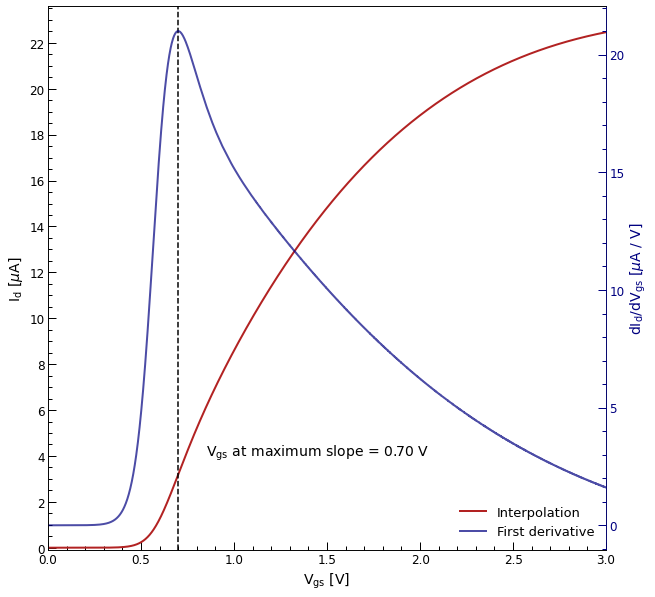

In [59]:
# interpolate simulation data
spline = UnivariateSpline(vgs, i*10**6,s=0)
# find dy/dx 
dydx = spline.derivative(n=1)

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(vgs, spline(vgs), color='firebrick', ls='-', 
                alpha=1, lw=2, label = 'Interpolation')
#ax.plot(vgs, i*10**6, lw=0, marker='o', mec='white',  alpha=0.7, markersize=7, 
#                color='firebrick', label = 'Simulation data')


ax.set_xlim(0,3.)
ax.set_ylim(bottom=-0.1)

# labels
ax.set_ylabel("I$_{\mathrm{d}}$ [$\mu$A]", fontsize=14)
ax.set_xlabel("V$_{\mathrm{gs}}$ [V]", fontsize=14)

set_ticks(ax, 0.5,2)

# set second y axis to plot derivative
ax2 = ax.twinx()

ax2.plot(vgs,dydx(vgs), color='navy', ls='-', alpha=0.7, lw=2, label = 'First derivative')

ax2.spines['right'].set_color('navy')
ax2.yaxis.label.set_color('navy') 
ax2.tick_params(axis='y',which = 'both', colors='navy')

# labels
ax2.set_ylabel("dI$_{\mathrm{d}}$/dV$_{\mathrm{gs}}$ [$\mu$A / V]", fontsize=14)

# ticks 
ax2.minorticks_on()
ax2.tick_params(which='major', width=1.0, length=8, direction="in", labelsize=12)
ax2.tick_params(which='minor', width=1.0, length=4, direction="in", labelsize=12)

# legend 
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=13, frameon=False)

# find maximum derivative point and corresponding gate voltage 
max_index = dydx(vgs).argmax()
max_voltage = vgs[max_index]

ax.axvline(max_voltage,ls = 'dashed',c = 'black')

text = 'V$_{\mathrm{gs}}$ at maximum slope = %1.2f V' % max_voltage

ax.text(0.85,4.,text,fontsize=14)

print('The point of maximum slope is found at %1.3f V' % max_voltage)

plt.show()

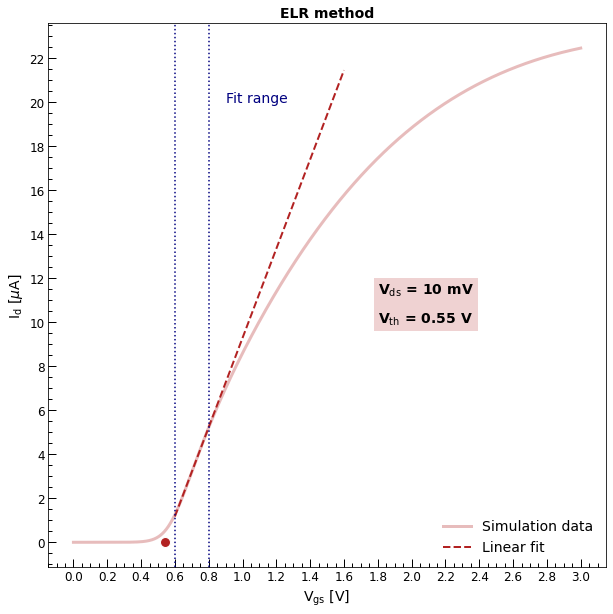

In [60]:
fig, ax = plt.subplots(figsize=(10,10))

# find fit range -> we choose vg in [max_voltage - 0.2,max_voltage + 0.2]
v_fit, i_fit = [], []
lower = max_voltage - 0.1
upper = max_voltage + 0.1

for index, v in np.ndenumerate(vgs):
    if v >= lower and v <= upper:
        v_fit.append(v)
        i_fit.append(i[index]*10**6)

params, _ = op.curve_fit(linfit, v_fit, i_fit)
domain = np.linspace(0.6, 1.6, 100)

ax.plot(vgs, i*10**6, color='firebrick', ls='-', alpha=0.3, lw=3, label = 'Simulation data')
ax.plot(domain, linfit(domain, *params), color='firebrick', ls='dashed',  lw=2,label='Linear fit')

ax.set_title('ELR method',fontsize=14, fontweight='bold')

# labels
ax.set_ylabel('I$_{\mathrm{d}}$ [$\mu$A]', fontsize=14)
ax.set_xlabel('V$_{\mathrm{gs}}$ [V]', fontsize=14)
# legend
ax.legend(loc=0, fontsize=14, frameon=False, ncol = 1)
set_ticks(ax, 0.2,2)

# calculate threshold voltage 
v_intercept  = -params[0]/params[1]
v_th = v_intercept + Vd/2

text = 'V$_{\mathrm{ds}}$ = 10 mV' + '\n' + 'V$_{\mathrm{th}}$ = %1.2f V' % v_th

ax.text(1.8,10,text,fontsize=14, fontweight='bold', linespacing = 2 ,
                bbox=dict(facecolor='firebrick',edgecolor='none', alpha=0.2))

# plot intercept point 
ax.plot(v_intercept,0,marker='o', mec='white', markersize=10, 
                color='firebrick' )
# plot fit range 
ax.axvline(lower,ls = 'dotted',c = 'navy')
ax.axvline(upper,ls = 'dotted',c = 'navy')

ax.text(0.9,20,'Fit range',fontsize=14, color = 'navy')

plt.show()


# Second-derivative (SD) method
This method determines the threshold voltage as the gate
voltage at which the second derivative of $\mathrm{I}_{\mathrm{d}}$ with respect to $\mathrm{V}_{\mathrm{gs}}$ is maximum.

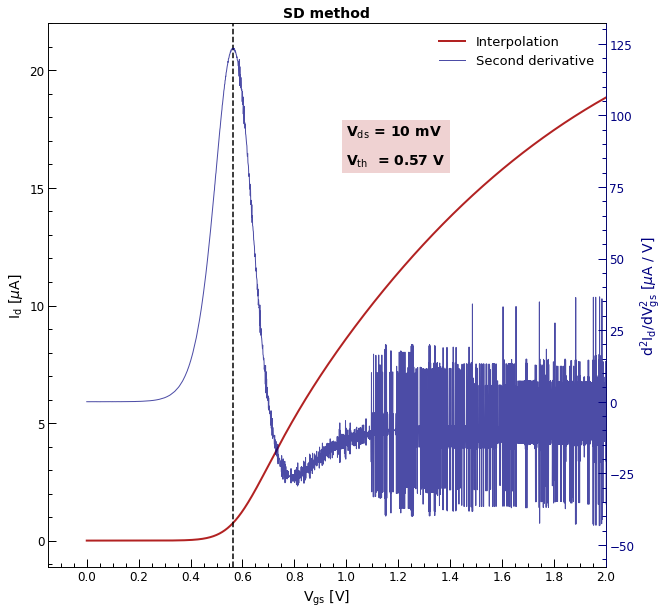

In [62]:
# find second derivative 
dydx2 = spline.derivative(n=2)

fig, ax = plt.subplots(figsize=(10,10))


ax.plot(vgs, spline(vgs), color='firebrick', ls='-', 
                alpha=1, lw=2, label = 'Interpolation')

ax.set_title("SD method",fontsize=14, fontweight='bold')

ax.set_ylim(top=22)
ax.set_xlim(right=2)

# labels
ax.set_ylabel("I$_{\mathrm{d}}$ [$\mu$A]", fontsize=14)
ax.set_xlabel("V$_{\mathrm{gs}}$ [V]", fontsize=14)

set_ticks(ax, 0.2,5)

# set second y axis to plot derivative
ax2 = ax.twinx()

ax2.plot(vgs,dydx2(vgs), color='navy', ls='-', alpha=0.7, lw=1, label = 'Second derivative')

ax2.spines['right'].set_color('navy')
ax2.yaxis.label.set_color('navy') 
ax2.tick_params(axis='y',which = 'both', colors='navy')

# labels
ax2.set_ylabel("d$^2$I$_{\mathrm{d}}$/dV$_{\mathrm{gs}}^2$ [$\mu$A / V]", fontsize=14)

# ticks 
ax2.minorticks_on()
ax2.tick_params(which='major', width=1.0, length=8, direction="in", labelsize=12)
ax2.tick_params(which='minor', width=1.0, length=4, direction="in", labelsize=12)

# legend 
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=13, frameon=False)

# find maximum derivative point and corresponding gate voltage 
max_index = dydx2(vgs).argmax()
max_voltage = vgs[max_index]

ax.axvline(max_voltage,ls = 'dashed',c = 'black')
text = 'V$_{\mathrm{ds}}$ = 10 mV' + '\n' + 'V$_{\mathrm{th}}$  = %1.2f V' % max_voltage

ax.text(1.,16,text,fontsize=14, fontweight='bold', linespacing = 2 ,
                bbox=dict(facecolor='firebrick',edgecolor='none', alpha=0.2))

plt.show()

***
## Analysis at fixed $\mathrm{V}_{\mathrm{gs}}$ and varying $\mathrm{V}_{\mathrm{ds}}$
***

In [115]:
# unpack data
files = ['700m.txt','800m.txt','900m.txt','1V.txt','1p1V.txt','1p2V.txt']
labels = [0.7,0.8,0.9,1,1.1,1.2]
colors = ['firebrick','navy','forestgreen','darkorange','darkviolet','royalblue']

for i in range(0,len(files)):
    globals()[f'vds{i}'],globals()[f'i_d{i}'] = np.loadtxt(files[i], unpack=True,skiprows=1)
vds = np.array([vds0,vds1,vds2,vds3,vds4,vds5])
i_d = np.array([i_d0,i_d1,i_d2,i_d3,i_d4,i_d5])

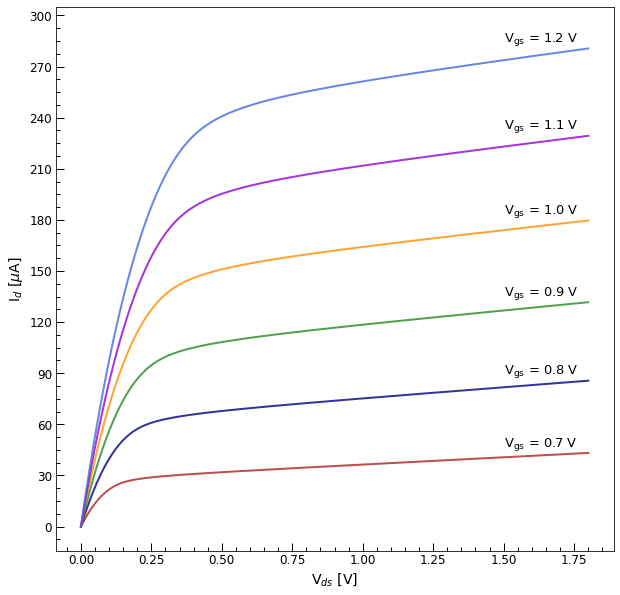

In [116]:
fig, ax = plt.subplots(figsize=(10,10))

for i in range(0,len(files)):
    ytext = i_d[i].max()*10**6 +4 
    ax.plot(vds[i], i_d[i]*10**6, color=colors[i], ls='-', alpha=0.8, lw=2)
    ax.text(1.5,ytext,'V$_{\mathrm{gs}}$ = %1.1f V' % labels[i],fontsize = 13)

# labels
ax.set_ylabel('I$_d$ [$\mu$A]', fontsize=14)
ax.set_xlabel('V$_{ds}$ [V]', fontsize=14)
ax.set_ylim(top=305)

lines, labels = ax.get_legend_handles_labels()
set_ticks(ax, 0.25,30)

plt.show()